# Point Transformer
https://github.com/qq456cvb/Point-Transformers

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False)

Mounted at /content/gdrive


In [2]:
import torch
!pip install open3d 1>/dev/null
%load_ext tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch.optim as optim
import numpy as np
from google.colab import output
output.enable_custom_widget_manager()

!pip install ipympl 1>/dev/null
%matplotlib widget

import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
from pytorch3d.loss.chamfer import chamfer_distance

In [4]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [5]:
#!git pull

In [6]:
from visuals.visuals_util import visualize_pointcloud, visualize_pointcloud_eval, visualize_pointcloud_eval_three

## Load dataset

In [7]:
from datasets.shapenet_data_pc import ShapeNet15kPointClouds

In [8]:
shapenet_location = "/content/gdrive/MyDrive/Developer/ShapeNetCore_pointclouds/ShapeNetCore.v2.PC15k"
num_points = 1024
upsampling = 2
tr_dataset = ShapeNet15kPointClouds(root_dir=shapenet_location,
    categories=["airplane"], split='train',
    tr_sample_size=num_points,
    te_sample_size=num_points*upsampling,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir=shapenet_location,
    categories=["airplane"], split='val',
    tr_sample_size=num_points,
    te_sample_size=num_points*upsampling,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir=shapenet_location,
    categories=["airplane"], split='test',
    tr_sample_size=num_points,
    te_sample_size=num_points*upsampling,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

len(tr_dataset), len(val_dataset), len(test_dataset)

Total number of data:2832
Min number of points: (train)1024 (test)2048
Total number of data:405
Min number of points: (train)1024 (test)2048
Total number of data:808
Min number of points: (train)1024 (test)2048


(2832, 405, 808)

In [9]:
batch_size = 20
train_dataloader = torch.utils.data.DataLoader(tr_dataset,
                                               batch_size=batch_size,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size=batch_size,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=batch_size,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)

## Load model

In [10]:
%cd /content/gdrive/MyDrive/Developer
# !git clone https://github.com/qq456cvb/Point-Transformers
%cd Point-Transformers

/content/gdrive/MyDrive/Developer
/content/gdrive/MyDrive/Developer/Point-Transformers


In [ ]:
!pip install -r requirements.txt

### Point Transformer Model

In [12]:
%cd /content/gdrive/MyDrive/Developer/Point-Transformers

/content/gdrive/MyDrive/Developer/Point-Transformers


In [15]:
import torch
import torch.nn as nn
from pointnet_util import PointNetFeaturePropagation, PointNetSetAbstraction
from models.Hengshuang.transformer import TransformerBlock


def encode_quarters(tensor):
    """
    Encode the quarters of points in a tensor of shape [batch_size, num_points, num_channels].

    :param tensor: Tensor of shape [batch_size, num_points, num_channels]
    :return: Modified tensor with encoded quarters in the last 2 feature dimensions.
    """
    batch_size, num_points, num_channels = tensor.shape
    quarter_size = num_points // 4

    # Creating the encoding for each quarter
    quarters = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=tensor.dtype, device=tensor.device)

    for b in range(batch_size):
        for q in range(4):
            start_idx = q * quarter_size
            end_idx = start_idx + quarter_size
            tensor[b, start_idx:end_idx, -2:] = quarters[q]

    return tensor


def quadruple_pointcloud(pc):
  """PC of shape Batch_size x Num_points x Cchannel"""
  return torch.cat([pc]*4, dim=1)

class TransitionDown(nn.Module):
    def __init__(self, k, nneighbor, channels):
        super().__init__()
        self.sa = PointNetSetAbstraction(k, 0, nneighbor, channels[0], channels[1:], group_all=False, knn=True)

    def forward(self, xyz, points):
        return self.sa(xyz, points)


class TransitionUp(nn.Module):
    def __init__(self, dim1, dim2, dim_out):
        class SwapAxes(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                return x.transpose(1, 2)

        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(dim1, dim_out),
            SwapAxes(),
            nn.BatchNorm1d(dim_out),  # TODO
            SwapAxes(),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(dim2, dim_out),
            SwapAxes(),
            nn.BatchNorm1d(dim_out),  # TODO
            SwapAxes(),
            nn.ReLU(),
        )
        self.fp = PointNetFeaturePropagation(-1, [])

    def forward(self, xyz1, points1, xyz2, points2):
        feats1 = self.fc1(points1)
        feats2 = self.fc2(points2)
        feats1 = self.fp(xyz2.transpose(1, 2), xyz1.transpose(1, 2), None, feats1.transpose(1, 2)).transpose(1, 2)
        return feats1 + feats2


class Backbone(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        npoints, nblocks, nneighbor, n_c, d_points = cfg.num_point, cfg.model.nblocks, cfg.model.nneighbor, cfg.num_class, cfg.input_dim
        self.fc1 = nn.Sequential(
            nn.Linear(d_points, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        self.transformer1 = TransformerBlock(32, cfg.model.transformer_dim, nneighbor)
        self.transition_downs = nn.ModuleList()
        self.transformers = nn.ModuleList()
        for i in range(nblocks):
            channel = 32 * 2 ** (i + 1)
            self.transition_downs.append(TransitionDown(npoints // 4 ** (i + 1), nneighbor, [channel // 2 + 3, channel, channel]))
            self.transformers.append(TransformerBlock(channel, cfg.model.transformer_dim, nneighbor))
        self.nblocks = nblocks

    def forward(self, x):
        xyz = x[..., :3]
        points = self.transformer1(xyz, self.fc1(x))[0]

        xyz_and_feats = [(xyz, points)]
        for i in range(self.nblocks):
            xyz, points = self.transition_downs[i](xyz, points)
            points = self.transformers[i](xyz, points)[0]
            xyz_and_feats.append((xyz, points))
        return points, xyz_and_feats


class PointTransformerCls(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.backbone = Backbone(cfg)
        npoints, nblocks, nneighbor, n_c, d_points = cfg.num_point, cfg.model.nblocks, cfg.model.nneighbor, cfg.num_class, cfg.input_dim
        self.fc2 = nn.Sequential(
            nn.Linear(32 * 2 ** nblocks, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, n_c)
        )
        self.nblocks = nblocks

    def forward(self, x):
        points, _ = self.backbone(x)
        res = self.fc2(points.mean(1))
        return res


class PointTransformerSeg(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.backbone = Backbone(cfg)
        npoints, nblocks, nneighbor, n_c, d_points = cfg.num_point, cfg.model.nblocks, cfg.model.nneighbor, cfg.num_class, cfg.input_dim
        # upsampling_ratio = cfg.model.upsampling_ratio
        # assert (upsampling_ratio & (upsampling_ratio - 1)) == 0, "upsampling_ratio must be a power of two"

        self.fc2 = nn.Sequential(
            nn.Linear(32 * 2 ** nblocks, 512),
            # nn.BatchNorm1d(512),  # Batch Normalization layer added
            nn.GELU(),
            nn.Linear(512, 512),
            # nn.BatchNorm1d(512),  # Batch Normalization layer added
            nn.GELU(),
            nn.Linear(512, 32 * 2 ** nblocks)
        )
        self.transformer2 = TransformerBlock(32 * 2 ** nblocks, cfg.model.transformer_dim, nneighbor)
        self.nblocks = nblocks
        self.transition_ups = nn.ModuleList()
        self.transformers = nn.ModuleList()
        for i in reversed(range(nblocks)):
            channel = 32 * 2 ** i
            self.transition_ups.append(TransitionUp(channel * 2, channel, channel))
            self.transformers.append(TransformerBlock(channel, cfg.model.transformer_dim, nneighbor))

        self.feature_expansion = nn.Sequential(
            nn.Conv1d(channel, channel*2, kernel_size=1),
            nn.Conv1d(channel*2, channel*2, kernel_size=1)
        )


        self.upsampling = TransitionUp(channel, channel//2, channel//2)
        self.upsamplings_transformers = TransformerBlock(channel//2, cfg.model.transformer_dim, nneighbor)


        self.fc3 = nn.Sequential(
            nn.Linear(32, 64),
            # nn.BatchNorm1d(64),
            # nn.LeakyReLU(),
            nn.GELU(),
            nn.Linear(64, 64),
            # nn.BatchNorm1d(64),
            # nn.LeakyReLU(),
            nn.GELU(),
            nn.Linear(64, n_c)
        )

    def forward(self, x):
        input = x
        points, xyz_and_feats = self.backbone(x)
        xyz = xyz_and_feats[-1][0]
        points = self.transformer2(xyz, self.fc2(points))[0]

        for i in range(self.nblocks):
            # print(f"{i}: {xyz.shape}, {points.shape}, {xyz_and_feats[- i - 2][0].shape}, {xyz_and_feats[- i - 2][1].shape}")
            points = self.transition_ups[i](xyz, points, xyz_and_feats[- i - 2][0], xyz_and_feats[- i - 2][1])
            xyz = xyz_and_feats[- i - 2][0]
            # print(f"{i}: {xyz.shape}, {points.shape}")
            points = self.transformers[i](xyz, points)[0]

        # print(f"after normal network: {points.shape}, {xyz.shape}")

        # upsample like PU-Net:
        # Feature expansion
        points = points.transpose(1, 2)
        points = self.feature_expansion(points)
        points = points.transpose(1, 2)
        points = points.reshape(-1, points.shape[1] * 2, points.shape[2] // 2)

        # print(f"After feature expansion: {points.shape}")

        # upsampling_xyz_and_feats = [torch.cat([xyz_and_feats[0][i]]*4, dim=1) for i in range(2)]
        # add one-hot-encoded feature vector
        # points = self.upsampling(xyz, points, upsampling_xyz_and_feats[0], encode_quarters(upsampling_xyz_and_feats[1][:, :, :16]))

        # xyz = xyz_and_feats[0][0]
        # points = self.upsamplings_transformers(upsampling_xyz_and_feats[0], points)[0]

        return torch.cat((input, input), dim=1) + self.fc3(points)

In [16]:
# from models.Hengshuang.model import PointTransformerSeg

patch_size = 512

class DotDict:
  pass

cfg = DotDict()
cfg.num_point = patch_size
cfg.model = DotDict()
cfg.model.nneighbor=32
cfg.model.nblocks=3
cfg.model.transformer_dim=512
cfg.num_class=3
cfg.input_dim = 3

model = PointTransformerSeg(cfg)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
_ = model.to(device)

# Losses
training_losses = []
val_losses = []
linearize_input = False

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total params: {total_params}, trainable params: {trainable_params}")

total params: 15932307, trainable params: 15932307


In [15]:
model.eval()
input = torch.rand(2, 512, 3).to(device)
with torch.no_grad():
  output = model(input)
print(f"input: {input.shape}, output: {output.shape}")

input: torch.Size([2, 512, 3]), output: torch.Size([2, 1024, 3])


## Patch creation

In [17]:
from pytorch3d.ops import knn_points
import torch

def ball_query_batch(batch, N, selected_points):
    # Find N nearest neighbors using PyTorch3D's knn_points
    # The 'p1' points are the randomly selected points, and 'p2' are the points in the batch
    batch_size, num_points, num_channels = batch.shape
    knn = knn_points(selected_points, batch, K=N)

    # Extract the indices of the nearest neighbors
    neighbor_indices = knn.idx.squeeze(1)  # Reshape to [batch_size, N]

    # Gather the nearest neighbors from the batch
    return torch.stack([batch[i].index_select(0, neighbor_indices[i]) for i in range(batch_size)])


def random_ball_query(batch, N):
    """
    For each point cloud in the batch, select a random point and find its N nearest neighbors using PyTorch3D.

    :param batch: Tensor of size [batch_size, num_points, num_channels]
    :param N: Number of nearest neighbors to find
    :return: Tensor of nearest neighbors of size [batch_size, N, num_channels] and points used for querying
    """
    batch_size, num_points, num_channels = batch.shape

    # Randomly select a point from each point cloud
    random_indices = torch.randint(num_points, (batch_size,))
    selected_points = batch[torch.arange(batch_size), random_indices].unsqueeze(1)

    return ball_query_batch(batch, N, selected_points), selected_points

## Train


In [17]:
# %tensorboard --logdir runs

In [18]:
# TensorBoard Logging with model's name and current date
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PointTransformer-Refinement-Part'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [19]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

import functools
from tqdm import tqdm
import itertools
from datetime import datetime

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


### Overfit on a single batch

In [20]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

In [ ]:
# input = torch.unsqueeze(tr_dataset[0]['train_points'], dim=0).to(device)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_directory = f"output-models/point_transformer/{timestamp}"
!mkdir {model_directory}

patience_counter = 0  # reset the patience counter

for epoch in range(100):
  total_train_loss = 0
  total_val_loss = 0

  # Train
  model.train()

  for batch in tqdm(train_dataloader):
    input = batch["train_points"].to(device)
    input_patches, selected_points = random_ball_query(input, patch_size)

    optimizer.zero_grad()
    # print(input_patches.shape, input_patches[0][0])
    output = model(input_patches)

    loss = chamfer_distance(output, ball_query_batch(batch["test_points"].to(device), patch_size * 2, selected_points=selected_points))[0]

    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()

  epoch_train_loss = total_train_loss / len(train_dataloader)
  training_losses.append(epoch_train_loss)

  lr_scheduler.step()

  model.eval()
  for batch in tqdm(val_dataloader):
    input = batch["train_points"].to(device)
    input_patches, selected_points = random_ball_query(input, patch_size)

    with torch.no_grad():
      output = model(input_patches)
      loss = chamfer_distance(output, ball_query_batch(batch["test_points"].to(device), patch_size * 2, selected_points=selected_points))[0]
      total_val_loss += loss.item()

  epoch_val_loss = total_val_loss / len(val_dataloader)
  val_losses.append(epoch_val_loss)

  writer.add_scalar('Loss/train', epoch_train_loss, epoch)
  writer.add_scalar('Loss/val', epoch_val_loss, epoch)


  summary = f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.8f}, Val loss: {epoch_val_loss:.8f}"

  # Check for improvement
  if epoch_val_loss < best_val_loss:
    best_val_loss = epoch_val_loss
    patience_counter = 0  # reset the patience counter
  else:
    patience_counter += 1
    summary += f" - No improvement in val loss for {patience_counter} epochs. ({best_val_loss:.8f})"

  print(summary)
  # Break the loop if patience exceeded
  if patience_counter >= patience:
    print("Stopping early due to no improvement in validation loss.")
    break


  # Save the model
  model_save_path = f"{model_directory}/Point-Transformer-e_{epoch+1:03d}.pth"
  torch.save(model.state_dict(), model_save_path)

# except Exception as e:
#   print("ERRROR DU DUMMER HSOHN")
#   print(e)
# finally:
#   from google.colab import runtime
#   runtime.unassign()

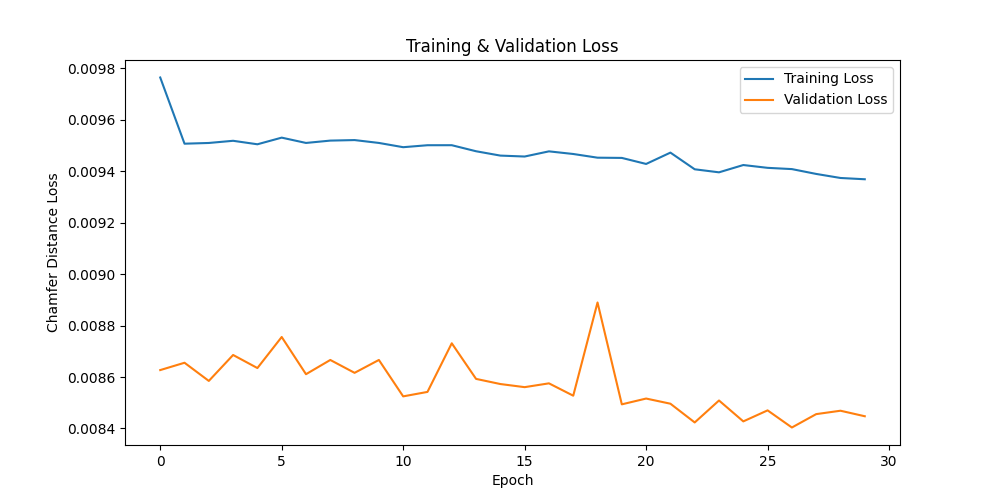

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss')
plt.legend()
plt.show()

## Visualize example

torch.Size([1, 512, 3]) torch.Size([1, 1, 3])


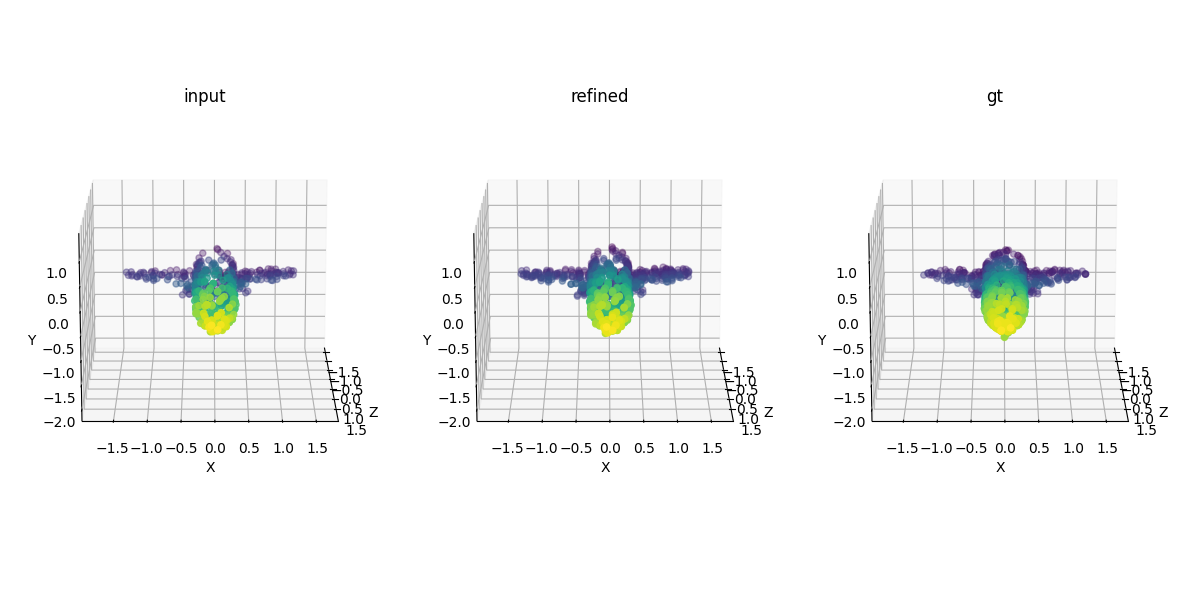

In [24]:
model.eval()

train_points, gt_points = (tr_dataset[0][typ].unsqueeze(dim=0).to(device) for typ in ('train_points', 'test_points'))
# print(train_points.shape, gt_points.shape)
input_patch, selected_point = random_ball_query(train_points, patch_size)
print(input_patch.shape, selected_point.shape)
with torch.no_grad():
  output = model(input_patch)
  # print(output.shape, noised_input.shape)
  _ = visualize_pointcloud_eval_three(input_patch, output, ball_query_batch(gt_points, patch_size * 2, selected_point), title1='input', title2='refined', title3='gt')

In [26]:
!mv {model_directory} {model_directory}_patch_upsampling

In [ ]:
try: optimizer.zero_grad()
except: pass
try: del output
except: pass
try: del loss
except: pass
try: del input
except: pass
try: del input_patches
except: pass
try: del optimizer
except: pass
try: del lr_scheduler
except: pass
torch.cuda.empty_cache()
import gc
gc.collect()
!nvidia-smi

In [ ]:
print(output[0][0], output[0][256])

## Concat both models

In [18]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
import torch
import torch.nn as nn
from pointnet_util import PointNetFeaturePropagation, PointNetSetAbstraction
from models.Hengshuang.transformer import TransformerBlock

class TransitionDown(nn.Module):
    def __init__(self, k, nneighbor, channels):
        super().__init__()
        self.sa = PointNetSetAbstraction(k, 0, nneighbor, channels[0], channels[1:], group_all=False, knn=True)

    def forward(self, xyz, points):
        return self.sa(xyz, points)


class TransitionUp(nn.Module):
    def __init__(self, dim1, dim2, dim_out):
        class SwapAxes(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                return x.transpose(1, 2)

        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(dim1, dim_out),
            SwapAxes(),
            nn.BatchNorm1d(dim_out),  # TODO
            SwapAxes(),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(dim2, dim_out),
            SwapAxes(),
            nn.BatchNorm1d(dim_out),  # TODO
            SwapAxes(),
            nn.ReLU(),
        )
        self.fp = PointNetFeaturePropagation(-1, [])

    def forward(self, xyz1, points1, xyz2, points2):
        feats1 = self.fc1(points1)
        feats2 = self.fc2(points2)
        feats1 = self.fp(xyz2.transpose(1, 2), xyz1.transpose(1, 2), None, feats1.transpose(1, 2)).transpose(1, 2)
        return feats1 + feats2


class Backbone(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        npoints, nblocks, nneighbor, n_c, d_points = cfg.num_point, cfg.model.nblocks, cfg.model.nneighbor, cfg.num_class, cfg.input_dim
        self.fc1 = nn.Sequential(
            nn.Linear(d_points, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        self.transformer1 = TransformerBlock(32, cfg.model.transformer_dim, nneighbor)
        self.transition_downs = nn.ModuleList()
        self.transformers = nn.ModuleList()
        for i in range(nblocks):
            channel = 32 * 2 ** (i + 1)
            self.transition_downs.append(TransitionDown(npoints // 4 ** (i + 1), nneighbor, [channel // 2 + 3, channel, channel]))
            self.transformers.append(TransformerBlock(channel, cfg.model.transformer_dim, nneighbor))
        self.nblocks = nblocks

    def forward(self, x):
        xyz = x[..., :3]
        points = self.transformer1(xyz, self.fc1(x))[0]

        xyz_and_feats = [(xyz, points)]
        for i in range(self.nblocks):
            xyz, points = self.transition_downs[i](xyz, points)
            points = self.transformers[i](xyz, points)[0]
            xyz_and_feats.append((xyz, points))
        return points, xyz_and_feats


class PointTransformerCls(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.backbone = Backbone(cfg)
        npoints, nblocks, nneighbor, n_c, d_points = cfg.num_point, cfg.model.nblocks, cfg.model.nneighbor, cfg.num_class, cfg.input_dim
        self.fc2 = nn.Sequential(
            nn.Linear(32 * 2 ** nblocks, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, n_c)
        )
        self.nblocks = nblocks

    def forward(self, x):
        points, _ = self.backbone(x)
        res = self.fc2(points.mean(1))
        return res


class PointTransformerRefinement(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.backbone = Backbone(cfg)
        npoints, nblocks, nneighbor, n_c, d_points = cfg.num_point, cfg.model.nblocks, cfg.model.nneighbor, cfg.num_class, cfg.input_dim
        self.fc2 = nn.Sequential(
            nn.Linear(32 * 2 ** nblocks, 512),
            # nn.BatchNorm1d(512),  # Batch Normalization layer added
            nn.GELU(),
            nn.Linear(512, 512),
            # nn.BatchNorm1d(512),  # Batch Normalization layer added
            nn.GELU(),
            nn.Linear(512, 32 * 2 ** nblocks)
        )
        self.transformer2 = TransformerBlock(32 * 2 ** nblocks, cfg.model.transformer_dim, nneighbor)
        self.nblocks = nblocks
        self.transition_ups = nn.ModuleList()
        self.transformers = nn.ModuleList()
        for i in reversed(range(nblocks)):
            channel = 32 * 2 ** i
            self.transition_ups.append(TransitionUp(channel * 2, channel, channel))
            self.transformers.append(TransformerBlock(channel, cfg.model.transformer_dim, nneighbor))

        self.fc3 = nn.Sequential(
            nn.Linear(32, 64),
            # nn.BatchNorm1d(64),
            # nn.LeakyReLU(),
            nn.GELU(),
            nn.Linear(64, 64),
            # nn.BatchNorm1d(64),
            # nn.LeakyReLU(),
            nn.GELU(),
            nn.Linear(64, n_c)
        )

    def forward(self, x):
        points, xyz_and_feats = self.backbone(x)
        xyz = xyz_and_feats[-1][0]
        points = self.transformer2(xyz, self.fc2(points))[0]

        for i in range(self.nblocks):
            points = self.transition_ups[i](xyz, points, xyz_and_feats[- i - 2][0], xyz_and_feats[- i - 2][1])
            xyz = xyz_and_feats[- i - 2][0]
            points = self.transformers[i](xyz, points)[0]

        return self.fc3(points)

cfg_refinment = DotDict()
cfg_refinment.num_point = 2048
cfg_refinment.model = DotDict()
cfg_refinment.model.nneighbor=32
cfg_refinment.model.nblocks=4
cfg_refinment.model.transformer_dim=512
cfg_refinment.num_class=3
cfg_refinment.input_dim = 3

refinement_model = PointTransformerRefinement(cfg_refinment)
_ = refinement_model.to(device)

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [19]:
refinement_model_save_path = "/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/output-models/point_transformer/2024-02-02_19-09-12_pt_global_refinment_no_residuals/Point-Transformer-e_009.pth"

In [20]:
# load best previous model:
refinement_model.load_state_dict(torch.load(refinement_model_save_path))
_ = model.eval()

In [22]:
model_save_path = "/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/output-models/point_transformer/2024-02-03_16-01-41_patch_upsampling/Point-Transformer-e_030.pth"
model.load_state_dict(torch.load(model_save_path))
_ = model.eval()

## Eval with PVD output

In [23]:
model.eval()
_ = refinement_model.eval()

In [24]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048*2,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd,
                                               batch_size=5,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)
print(len(dataset_pvd))

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
Total number of data:400
Min number of points: (train)2048 (test)4096
400


In [52]:
print([dataset_pvd[0][typ].shape for typ in ['train_points', 'test_points']])

[torch.Size([2048, 3]), torch.Size([4096, 3])]


In [ ]:
visualize_pointcloud(dataset_pvd[0]['test_points'])

In [ ]:
!git pull

In [31]:
import torch
from pytorch3d.ops import knn_points

def ball_query_batch_masked(batch, N, selected_points, mask):
    """
    Adapted ball_query_batch function that considers a mask to exclude already selected points.

    Parameters:
    - batch (torch.Tensor): The batch of point clouds, shape [batch_size, num_points, num_channels].
    - N (int): The number of nearest neighbors to find.
    - selected_points (torch.Tensor): The selected points, shape [batch_size, num_selected_points, num_channels].
    - mask (torch.Tensor): A boolean tensor indicating available points, shape [batch_size, num_points].

    Returns:
    - torch.Tensor: The nearest neighbors for the selected points considering the mask.
    - torch.Tensor: Updated mask after selecting points.
    """
    batch_size, num_points, num_channels = batch.shape
    # Apply mask to exclude points from batch
    masked_batch = torch.where(mask.unsqueeze(-1), batch, torch.tensor(float('inf')).to(batch.device))
    knn = knn_points(selected_points, masked_batch, K=N)

    # Update mask to exclude selected points
    new_mask = mask.clone()
    for i in range(batch_size):
        new_mask[i, knn.idx[i]] = False

    # Extract the indices of the nearest neighbors
    neighbor_indices = knn.idx.squeeze(1)

    # Gather the nearest neighbors from the batch considering the mask
    patches = torch.stack([batch[i].index_select(0, neighbor_indices[i].view(-1)).view(-1, N, num_channels) for i in range(batch_size)])
    return patches, new_mask

def get_patches_with_nearest_neighbors_exclusion(point_cloud, patch_size):
    B, N, _ = point_cloud.shape
    if N % patch_size != 0:
        raise ValueError("N must be divisible by patch_size.")

    # Initialize mask to keep track of selected points (True indicates available)
    mask = torch.ones(B, N, dtype=torch.bool, device=point_cloud.device)
    patches_list = []
    for _ in range(N // patch_size):
        # Calculate indices of available points for each batch
        available_indices = [torch.nonzero(mask[b], as_tuple=False).squeeze(1) for b in range(B)]
        selected_points_list = []

        for b in range(B):
            # Ensure there are enough available points to select from
            if len(available_indices[b]) < patch_size:
                raise ValueError("Not enough points to form a patch. Consider reducing patch_size.")
            # Randomly select center point index from available indices
            selected_index = available_indices[b][torch.randint(len(available_indices[b]), (1,))]
            selected_point = point_cloud[b, selected_index]
            selected_points_list.append(selected_point)

        selected_points = torch.stack(selected_points_list)

        # Find nearest neighbors for selected points considering the mask
        patches, new_mask = ball_query_batch_masked(point_cloud, patch_size, selected_points, mask)
        mask = new_mask
        patches_list.append(patches)

    # Concatenate patches to match desired output shape
    patches = torch.cat(patches_list, dim=1)
    return patches

In [ ]:
pc = dataset_pvd[0]['train_points'].unsqueeze(0)
patch_size = 512
# visualize_pointcloud(pc)
patches = get_patches_with_nearest_neighbors_exclusion(pc, patch_size).squeeze()
print(patches.shape)
for patch in patches:
  pass
  # visualize_pointcloud(patch)

In [ ]:
input = dataset_pvd[0]['train_points'].to(device).unsqueeze(0)
gt = dataset_pvd[0]['test_points'].to(device)
with torch.no_grad():
  refined_input = refinement_model(input) + input
  output = model(refined_input)
# visualize_pointcloud_eval(input, refined_input)
visualize_pointcloud_eval_three(input, output, gt)

In [56]:
patches = get_patches_with_nearest_neighbors_exclusion(refined_input, patch_size)
batch_size, patch_count, points_count, channels = patches.shape
patches = patches.squeeze()
with torch.no_grad():
  refined_patches = model(patches)

i just tried to train a second model on upsampling and use both to refine and then upsample this airplane, but tbh doesn’t look too good (left refined, right output)

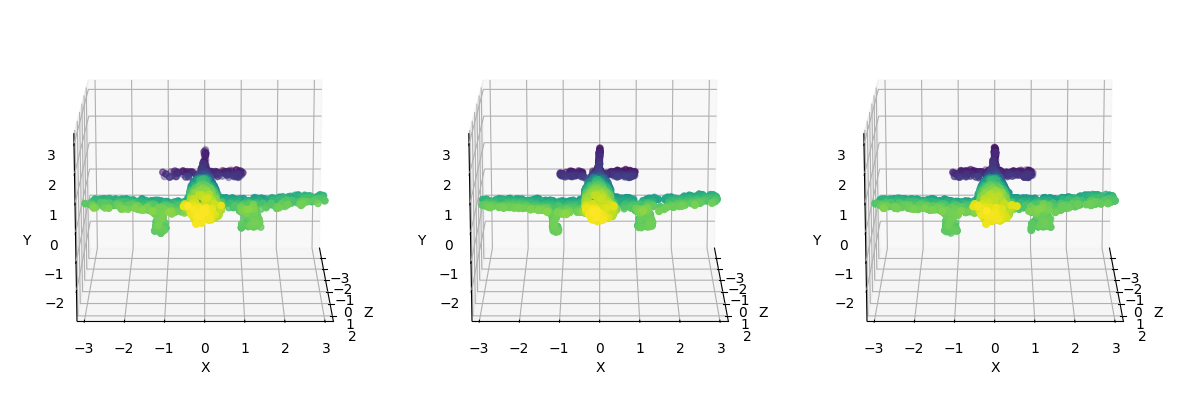

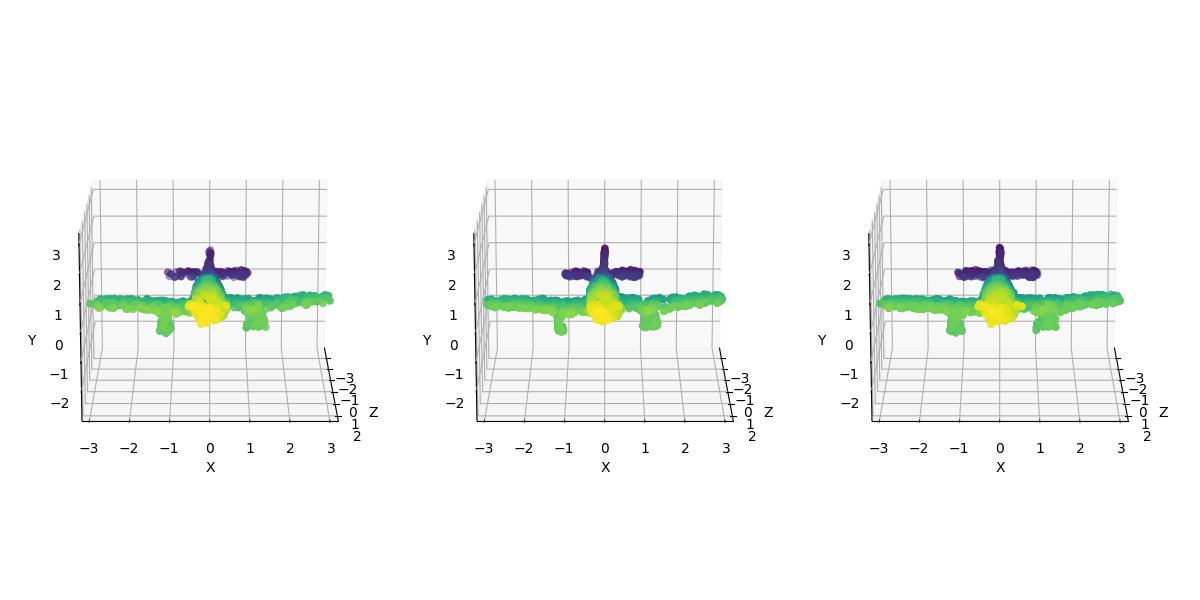

In [62]:
visualize_pointcloud_eval_three(dataset_pvd[0]['train_points'], refined_patches.view(-1, 3), dataset_pvd[0]['test_points'])

In [64]:
!pip install mitsuba
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 59.0 MB/s eta 0:00:00


In [70]:
index = 0
names = ['input', 'refined', 'gt']
print([x.shape for x in (dataset_pvd[0]['train_points'], refined_patches.view(-1, 3), dataset_pvd[0]['test_points'])])
for point_cloud in (dataset_pvd[0]['train_points'], refined_patches.view(-1, 3), dataset_pvd[0]['test_points']):
  plot_name = f".visuals/pt-refined-and-upsampled-{names[index]}"
  print(point_cloud.shape)
  img = render_mitsuba(point_cloud=point_cloud, filepath=f"{plot_name}.xml", fov=20)
  plt.axis("off")
  plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping
  plt.savefig(f"{plot_name}.png", bbox_inches='tight', pad_inches=0, dpi=400)

[torch.Size([2048, 3]), torch.Size([4096, 3]), torch.Size([4096, 3])]
torch.Size([2048, 3])


TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=int, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


In [ ]:
# timestamp = "2024-01-30_23-46-44"

In [ ]:
from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud
from utils.export import export_pointcloud_to_asc, export_pointcloud_to_pts
from pathlib import Path
from google.colab import files

model.eval()

base_path = Path(f"./visuals/point-transformer/{timestamp}/")
base_path.mkdir(parents=True, exist_ok=True)

for i in range(10):
  input = dataset_pvd[i]['test_points'].to(device).unsqueeze(0)
  with torch.no_grad():
    output = model(input)
  loss = chamfer_distance(input, input + output)[0]
  print(f"{i}, residual CD: {loss}")
  print(input.shape, output.shape, input.mean(), output.mean(), input.std(), output.std())
  visualize_pointcloud_eval_three(input.squeeze().cpu(), output.squeeze().cpu(), (input+output).squeeze().cpu())
  instance_path = f"{(base_path / f'{i:02d}').absolute()}-"
  torch.save(input.squeeze(), instance_path + "input.pth")
  torch.save(output.squeeze(), instance_path + "residuals.pth")
  torch.save((input + output).squeeze(), instance_path + "refined_output.pth")

# visualize_pointcloud_eval(rotate_point_cloud_y(input.squeeze().cpu(), -45), rotate_point_cloud_y((input + output).squeeze().cpu(), -45))
# visualize_pointcloud_eval(rotate_point_cloud_y(input.squeeze().cpu(), 45), rotate_point_cloud_y((input + output).squeeze().cpu(), 45))

## Eval like in PVD

In [ ]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

input_array = []

for batch in val_dataloader:
  input = batch["test_points"].to("cuda")
  input_array.append(input)

In [ ]:
output_array = []

model.eval()
for batch in tqdm(dataloader_pvd):
  input = batch["train_points"].to(device)
  noised_input = noise_fct(input)

  with torch.no_grad():
    output = model(noised_input)
    output_array.append(output + input)

In [ ]:
print(input_array[0][0].shape)

In [ ]:
visualize_pointcloud_eval(input_array[0][0], output_array[0][0])

In [ ]:
print(len(input_array), len(output_array))
print(input_array[0].shape, output_array[0].shape)

In [ ]:
from pathlib import Path
input_pcs = torch.stack(input_array).view(405, 2048, 3)
output_pcs = torch.stack(output_array).view(400, 2048, 3)

base = Path("/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/eval-results/point-transformer/2024-01-30_23-46-44_global_refinment")
base.mkdir(parents=True, exist_ok=True)
torch.save(input_pcs, f"{base}/input_pcs.pt")
torch.save(output_pcs, f"{base}/output_pcs.pt")

In [ ]:
!git add {base}
!git commit -m "add point transformer eval tensors"
!git push

## Utils

In [ ]:
optimizer.zero_grad()
torch.cuda.empty_cache()
import gc
gc.collect()
!nvidia-smi

In [ ]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
!git status

In [ ]:
!git add visuals/point-transformer/

In [ ]:
!git commit -m "Add PointTransformer global refinment results"
!git push

In [ ]:
from google.colab import files
zip_name = f"{base_path}.zip"
!zip -r {zip_name} {str(base_path)}
files.download(zip_name)

In [ ]:
# Save the model
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
from datetime import datetime
model_save_path = f"output-models/point_transformer/PointTransformer-{datetime.now().strftime('%Y-%m-%d_%H-%M')}.pth"
torch.save(model.state_dict(), model_save_path)
!git add .
!git status

In [ ]:
!git add .
!git commit -m "Add new model"
!git push

In [ ]:
# input = torch.unsqueeze(tr_dataset[0]['train_points'], dim=0).to(device)[:,:1024]
# with torch.no_grad():
#   output = model(noised_input)
# print(input.shape, output.shape)
# visualize_pointcloud(output.cpu())

In [ ]:
input = input.squeeze().cpu()
device="cpu"
visualize_pointcloud_eval_three(input, add_random_noise(input), add_random_noise(input, std=0.1))

In [ ]:
from google.colab import runtime
runtime.unassign()